# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000001,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000001,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000001,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, i.e that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [48]:
import h5py
f = h5py.File("dataset.hdf5", "r")

In [49]:
timestamps = f['timestamps']
latitudes = f['latitudes']
longitudes = f['longitudes']

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import random
dataset = list(zip(latitudes, longitudes))
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

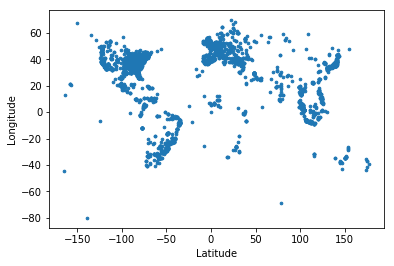

In [54]:
plt.scatter(sample_latitudes, sample_longitudes, s=7)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

## Algorithmic part

Here we develop several versions of k-centers clustering.

### Metric definition

First we define a metric to have a notion of distance between points. An intuitive metric would be the euclidean one, since we are in two-dimensional space. But many other metrics are provided by the Python library SciPy.

In [72]:
from scipy.spatial.distance import pdist
test = np.asarray(dataset)
print(test)
print(((0.37-121)**2+(52-14)**2)**0.5)
print((61**2+(52+27)**2)**0.5)
distances = pdist (test, 'euclidean')


[[   0.37526667   52.26389694]
 [ 121.03524017   14.65166569]
 [ -61.2051506   -27.21325874]
 ..., 
 [ 130.23036194   33.30177689]
 [ 139.69612122   35.5321312 ]
 [   0.            0.        ]]
126.47370042819179
99.80981915623332


MemoryError: 

In [70]:
index_to_points = {}
n = 100
count_i = 0
count_j = 0
for i in range(0, len(distances)):
    count_j += 1
    if count_j == n-1:
        count_i += 1
        count_j = count_i + 1
    index_to_points[i] = [count_i, count_j]
    

NameError: name 'distances' is not defined

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 4
3 5
3 6
